<a href="https://colab.research.google.com/github/ingabLee/Transformers_book/blob/main/Transformer_09_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install transformers==4.30.0
#!pip install torchtext==0.15.2
#!pip install portalocker==2.7.0
#!pip install accelerate -U
#!pip install torch==2.6.0

#!python --version

!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext==0.17.0 torchdata
!pip3 install portalocker
!pip3 install accelerate
!pip3 install transformers

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take

In [2]:
import numpy as np
import torch
import torchtext

print(torch.__version__)
print(torchtext.__version__)

a = np.array([0,0,1])
b = torch.Tensor(a)
print(a)
print(b)

c = b.tolist()
print(c)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

2.2.0+cu121
0.17.0+cpu
[0 0 1]
tensor([0., 0., 1.])
[0.0, 0.0, 1.0]


In [3]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

# 출력 결과를 고정하기 위해
import random
random.seed(6)

# train_iter를 리스트 타입으로 변경
train_list = list(train_iter)
test_list = list(test_iter)

# 각기 1000개씩 random sampling
train_list_small = random.sample(train_list, 1000)
test_list_small = random.sample(test_list, 1000)

# 각 변수에 담긴 인덱스 0의 내용 화면 출력
print(train_list_small[0])
print(test_list_small[0])

(2, "I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.")
(1, 'This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Tru

In [4]:
# train_text, train_label 컨테이너 생성
# 아래 반복문에서 생성된 결과를 담는다.
train_texts = []
train_labels = []

#for 반복문
# train_list_small에 담긴 튜플쌍 원소를 변수명 label, test부여하여 순서대로 축출
for label, text in train_list_small:
  # IMDB 데이터의 기존 레이블 2를 1로 변경, 기존 레이블 1을 0으로 변경.
  train_labels.append(1 if label == 2 else 0)
  train_texts.append(text)

# test_list_small도 동일하게 처리
test_texts = []
test_labels = []
for label, text in test_list_small:
  test_labels.append(1 if label==2 else 0)
  test_texts.append(text)

# 각 변수에 담긴 첫번째 원소 출력
print(train_texts[0])
print(train_labels[0])
print(test_texts[0])
print(test_labels[0])

I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.
1
This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Truly a horri

In [5]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,random_state=3)

print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_labels))

800
800
200
200


In [6]:
# distilbert-base-uncased 모델에서 tokenizer 불러오기
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
# tokenizer execute
# truncation=True -> 모델의 default max_length를 넘는 입력부분은 더이상 받지않고 절단한다는 의미
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# 0번째 입력문의 5번째 토큰까지 input_ids출력
print(train_encodings["input_ids"][0][:5])

#위의 결과를 다시 디코딩해서 출력
print(tokenizer.decode(train_encodings["input_ids"][0][:5]))

[101, 4937, 11350, 2038, 2048]
[CLS] cat soup has two


In [8]:
import torch

# Dataset 클래스를 상속하는 IMDB class정의
class IMdbDataset(torch.utils.data.Dataset):

  # contructor
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  #
  def __getitem__(self, idx):
    # self.encoding에 담긴 키(key)와 키값(value)를 items()로 축출
    # 이 값을 key와 val 변수에 담아 새로운 키와 키값(torch.tensor(val[idx]))을 갖는 딕셔너리 생성

    # 딕셔너리{"key1 : value1", ...} 형태를 가지는 데이터 구조.
    # val[idx]에 담긴 데이터를 torch.tensor()을 통해 텐셔화.
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items() }

    # tensor화
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  #
  def __len__(self):
    return len(self.labels)

train_dataset = IMdbDataset(train_encodings, train_labels)
val_dataset = IMdbDataset(val_encodings, val_labels)
test_dataset = IMdbDataset(test_encodings, test_labels)

for i in train_dataset:
  print(i)
  break

{'input_ids': tensor([  101,  4937, 11350,  2038,  2048,  1000,  7592, 14433,  1000,  1011,
         2828, 18401,  2015, 28866,  2075,  2006,  1037, 13576,  4440,  2083,
         1996, 25115,  1010,  2073,  2505,  2064,  4148,  1010,  1998,  2515,
         1012,  2023,  2568,  1011,  4440,  4691,  4004,  2460,  3594,  2053,
        13764,  8649,  1010,  4942, 21532,  2773, 22163,  2612,  1012,  2045,
         2003,  2053,  2126,  1997,  7851,  2023, 17183, 14088,  9476,  3272,
         2000,  2425,  2017,  2000,  2156,  2009,  2005,  4426,  1012,  1998,
         2191,  2469,  2053,  2028,  2104,  2184,  2003,  1999,  1996,  2282,
         1012,  4487,  6491,  6633,  5677,  3672,  1998,  2064,  3490, 10264,
         2964,  1998, 18186,  1998,  9576,  2854,  1998,  5573,  2331,  1998,
         2655,  3560, 27770,  2005,  2500,  2024,  2691,  6991,  1012,  7481,
         1012,  3383,  1996,  2087, 13432,  3746,  2003,  2008,  1997,  2019,
        10777,  3605,  1997,  2300,  2008,  1996, 

In [9]:
from transformers import DistilBertForSequenceClassification

# load distilbert model.  (need transformers==4.30.0)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./result',    # 출력 폴더 설정
    num_train_epochs=8,       # training epochs count
    per_device_train_batch_size=16, # train mini-batch size
    per_device_eval_batch_size=64,  # eval min-batch size
    warmup_steps=500,   # learning-rate scheduling warmup step
    weight_decay=0.01,  # 가중치 감소 강도
    logging_dir='./logs',   #로그 폴더 경로
    logging_steps=10
)

In [11]:
#import torch

# gpu사용이 가능한 경우 tensor타입를 gpu로 전달
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
# fine-tunning이전에 세입력 문장 극성 판별
# tokenizing
input_tokens = tokenizer(["I feel fantasic",
                          "My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],
                         truncation=True, padding=True)

# input text tokenizing result에 담긴 input_ids를 모델에 투입
# 그리고 모델 출력 결과를 gpu로 전송하며 값은 변수 outputs에 저장
outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

# create label dictionary
label_dict = {0:'positvie', 1:'negative'}
print(outputs['logits'])


# outputs변수에 담긴 logits값을 행단위, 즉, 입력문장 단위로 가장 큰값의 위치(인덱스) 추출
# 결과값(인덱스)을 cpu로 넘기고 넘파이 타입으로 변경후, 인덱스에 매칭되는 레이블 출력

#print([label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()])
v = torch.argmax(outputs['logits'], axis=1)
print(v)
#print(v.cpu().numpy())
#print(torch.__version__)

w = v.tolist()
print([label_dict[i] for i in w])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 0.0202,  0.0173],
        [-0.0147,  0.0429],
        [-0.0333,  0.0263]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0, 1, 1], device='cuda:0')
['positvie', 'negative', 'negative']


In [13]:
# maybe 5minute

from transformers import Trainer
trainer = Trainer(
    model=model,      # pretrain model instance
    args = training_args, # transformer.Arguments define hyper parameter
    train_dataset = train_dataset,  # train data set
    eval_dataset = val_dataset    # evaluation data set
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ingab-lee (ingab-lee-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.687600
20,0.691500
30,0.695500
40,0.684300
50,0.685700
60,0.676500
70,0.670700
80,0.663800
90,0.620200
100,0.538700


TrainOutput(global_step=400, training_loss=0.2863732507964596, metrics={'train_runtime': 354.2329, 'train_samples_per_second': 18.067, 'train_steps_per_second': 1.129, 'total_flos': 847791351398400.0, 'train_loss': 0.2863732507964596, 'epoch': 8.0})

In [21]:
# after fine-tunning. then try again three text

input_tokens = tokenizer(["I feel fantastic",
                          "My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],
                         truncation=True, padding=True)

# input text tokenizing result에 담긴 input_ids를 모델에 투입
# 그리고 모델 출력 결과를 gpu로 전송하며 값은 변수 outputs에 저장
outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

# create label dictionary
label_dict = {1:'positvie', 0:'negative'}
print(outputs['logits'])


# outputs변수에 담긴 logits값을 행단위, 즉, 입력문장 단위로 가장 큰값의 위치(인덱스) 추출
# 결과값(인덱스)을 cpu로 넘기고 넘파이 타입으로 변경후, 인덱스에 매칭되는 레이블 출력

#print([label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()])
v = torch.argmax(outputs['logits'], axis=1).tolist()
print([label_dict[i] for i in v])

tensor([[-1.4967,  1.2730],
        [ 2.9971, -2.5817],
        [ 0.7045, -0.5044]], device='cuda:0', grad_fn=<AddmmBackward0>)
['positvie', 'negative', 'negative']


In [22]:
# make function
def test_inference(model, tokenizer):
  input_tokens = tokenizer(["I feel fantastic",
                          "My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],
                         truncation=True, padding=True)

  # input text tokenizing result에 담긴 input_ids를 모델에 투입
  # 그리고 모델 출력 결과를 gpu로 전송하며 값은 변수 outputs에 저장
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

  # create label dictionary
  label_dict = {1:'positvie', 0:'negative'}

  # outputs변수에 담긴 logits값을 행단위, 즉, 입력문장 단위로 가장 큰값의 위치(인덱스) 추출
  # 결과값(인덱스)을 cpu로 넘기고 넘파이 타입으로 변경후, 인덱스에 매칭되는 레이블 출력

  v = torch.argmax(outputs['logits'], axis=1).tolist()
  return [label_dict[i] for i in v]

In [19]:
# maybe 5minute take time
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

# 1) load pretrain model and tokenizer
# add to code ( output of model "to(device)" ) 가능한 경우 결과를 gpu에 전달
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

#print result of before fine tunning
print(test_inference(model, tokenizer))

# 2) Dataloader instance
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 3) define optimize
optim = AdamW(model.parameters(), lr=5e-5)

# 4) 모델을 학습(train)모드로 전환
# 학습모드 전환은 dropout, batch-normalization에 영향을 미침
model.train()

losses=[]

# 5) for loop epochs count
for epoch in range(8):
  print(f'epoch:{epoch}')
  for batch in train_loader:
    # 6) init optimize function gradient
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # 7) inference model
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # 8) calc loss
    loss = outputs[0]
    losses.append(loss)

    # 9) backward error
    loss.backward()

    # 10) update weight
    optim.step()

# change mode evaluate model
model.eval()

# run test_inference in eval mode.
print(test_inference(model, tokenizer))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['positvie', 'negative', 'negative']
epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
['negative', 'negative', 'negative']


In [23]:
print(test_inference(model, tokenizer))
print(losses)
type(losses)

['positvie', 'negative', 'negative']
[tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6612, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.8364, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6284, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6456, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6756, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6857, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6812, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6890, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6980, device='cuda:0', grad_fn=<NllLos

list

In [27]:
# pytorch에서 item은 tensor값을 python number로 추출하여 cpu에 전달
new_losses = [i.item() for i in losses]

# display first 5 items
new_losses[:5]
type(new_losses)

list

In [28]:
new_losses[-5:]

[0.003761313622817397,
 0.00255848397500813,
 0.0031397738493978977,
 0.002798669971525669,
 0.0034540772903710604]

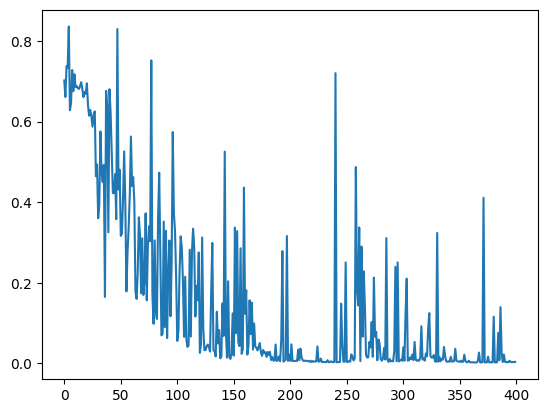

In [30]:
import matplotlib.pyplot as plt
plt.plot(new_losses)
plt.show()